In [1]:
import pandas as pd
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import join
from os import listdir
import os
from sklearn.model_selection import train_test_split
from scipy.signal import welch
from scipy.fftpack import fft
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from fonction import *
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Using TensorFlow backend.


In [2]:
data = pd.read_csv(r"all_data2.csv", sep=";")
data_val = pd.read_csv(r"all_data4.csv", sep=";")
#data3 = data3[data3["defaut"]==0]
#data4 = pd.read_csv(r"all_data4.csv", sep=";")
#data = pd.concat([data3,data2], ignore_index=True)
data=data[data['defaut']==1]
#data=data_val[data_val['defaut']==1]

In [3]:
TIME_STEPS = 404
STEP = 150

In [4]:
X= np.zeros(shape=(1,404,8))
Y=np.zeros(shape=(1,1))
Angle= np.zeros(shape=(1,1))
Obs=np.zeros(shape=(1,1))
for i in set(data['angle']):
    for j in set(data['obs']):
        for k in set(data[(data['angle']==i) & (data['obs']==j)]['size']):
            x,y, angle, obs= create_dataset_kmean(data[(data['angle']==i) & (data['obs']==j) & (data['size']==k)][['temp','rpm','acc_x', 'acc_y','acc_z','gyr_x', 'gyr_y','gyr_z']], 
                            data[(data['angle']==i) & (data['obs']==j) & (data['size']==k)]['defaut'],
                            data[(data['angle']==i) & (data['obs']==j) & (data['size']==k)]['angle'],
                            data[(data['angle']==i) & (data['obs']==j) & (data['size']==k)]['obs'],TIME_STEPS, STEP)
            X=np.concatenate((X,x))
            Y=np.concatenate((Y,y))
            Angle=np.concatenate((Angle,angle))
            Obs=np.concatenate((Obs,obs))
X=X[1:len(X)]
Y=Y[1:len(Y)]
Angle=Angle[1:len(Angle)]
Obs=Obs[1:len(Obs)]

In [5]:
X_val= np.zeros(shape=(1,404,8))
Y_val=np.zeros(shape=(1,1))
Angle_val= np.zeros(shape=(1,1))
Obs_val=np.zeros(shape=(1,1))
for i in set(data_val['angle']):
    for j in set(data_val['obs']):
        for k in set(data_val[(data_val['angle']==i) & (data_val['obs']==j)]['size']):
            x_val,y_val, angle_val, obs_val= create_dataset_kmean(data_val[(data_val['angle']==i) & (data_val['obs']==j) & (data_val['size']==k)][['temp','rpm','acc_x', 'acc_y','acc_z','gyr_x', 'gyr_y','gyr_z']], 
                            data_val[(data_val['angle']==i) & (data_val['obs']==j) & (data_val['size']==k)]['defaut'], 
                            data_val[(data_val['angle']==i) & (data_val['obs']==j) & (data_val['size']==k)]['angle'],
                            data_val[(data_val['angle']==i) & (data_val['obs']==j) & (data_val['size']==k)]['obs'],TIME_STEPS, STEP)
            X_val=np.concatenate((X_val,x_val))
            Y_val=np.concatenate((Y_val,y_val))
            Angle_val=np.concatenate((Angle_val,angle_val))
            Obs_val=np.concatenate((Obs_val,obs_val))
X_val=X_val[1:len(X_val)]
Y_val=Y_val[1:len(Y_val)]
Angle_val=Angle_val[1:len(Angle_val)]
Obs_val=Obs_val[1:len(Obs_val)]

In [6]:
from sklearn.model_selection import train_test_split
Fs = 75 #Sampling frequency (Hz)
window_time = 5 #Seconds

""" SET WINDOW SIZE """
window_size =  404 
step=1.33 #we will use a sliding window with step = 4
T = window_time / window_size

In [7]:
Obs.shape

(2768, 1)

In [8]:
X_train, Y_train, angle, obs = extract_features_kmean(X, Y, Angle, Obs, T, window_size, Fs, 16)
#X_val1, Y_val1 = extract_features_kmean(X_val, Y_val, T, window_size, Fs, 16)

In [9]:
Sum_of_squared_distances = []
K = [40,41,42,45, 46, 47, 47, 49, 50]
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

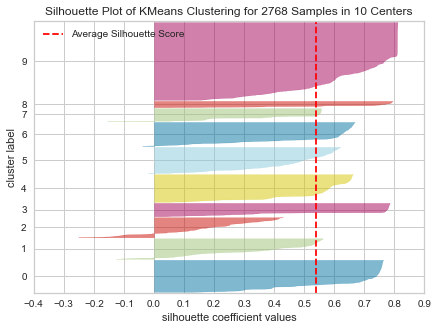

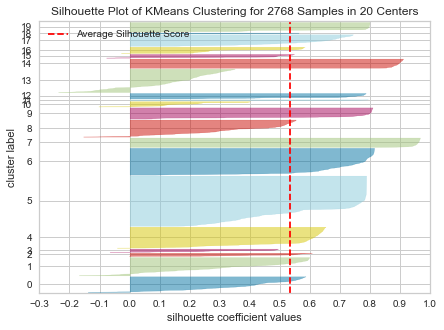

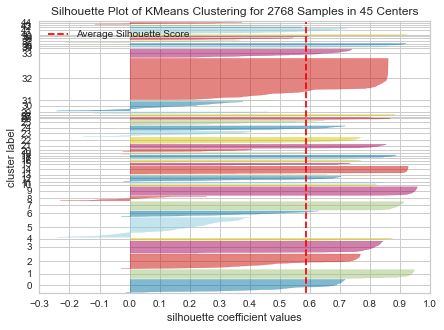

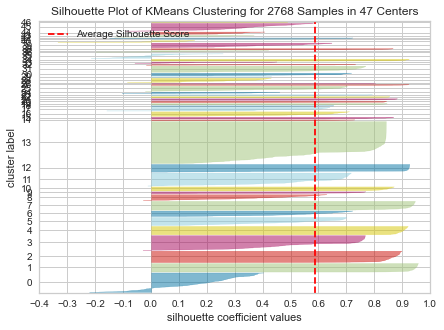

In [10]:
for k in [10, 20, 45,  47]:
    fig, ax = plt.subplots(1, 1, figsize=(7,5))
    
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
    visualizer.fit(X_train)
    visualizer.show()
 

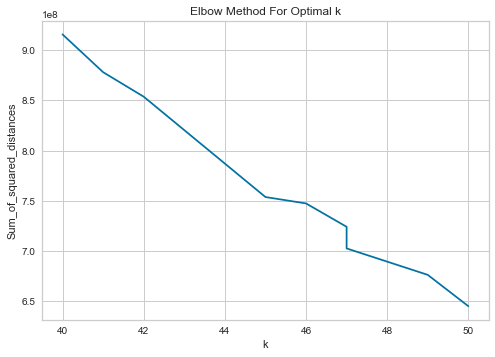

In [11]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:
# Instantiate the KMeans models
#
km = KMeans(n_clusters=45, init='k-means++', n_init=10, max_iter=10, random_state=42)
#
# Fit the KMeans model
#
km.fit_predict(X_train)
#
# Calculate Silhoutte Score
#
score = silhouette_score(X_train, km.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.585


In [13]:
dat=pd.DataFrame(list(zip(angle,obs, km.labels_)), columns = ['angle','obs', 'labels'])

In [14]:
for i in range(0,len(dat)):
    dat.iloc[i,0]=dat.iloc[i,0][0]
    dat.iloc[i,1]=dat.iloc[i,1][0]
    dat.loc[i,'labels']="classe"+str(dat.loc[i,'labels'])
    dat.loc[i,'cat']=str(int(dat.iloc[i,0]))+'°'+ '_'+str(dat.iloc[i,1])+'%'
    dat.loc[i,'num']=1

In [15]:
table = pd.pivot_table(dat, values='num', index=['labels'],columns=['cat'], aggfunc=np.sum).fillna(0).reset_index()
table1 = pd.pivot_table(dat, values='num', index=['labels'],columns=['cat'], aggfunc=np.sum).fillna(0)

In [16]:
def plot_cluster_radar(data, cluster_label, features=None, center=np.mean, ax=None, figsize=(8,8), legend_loc=(1.3,0.9), labels=None): 
    if data.__class__.__name__ == 'DataFrame':
        hasClusterInDF = cluster_label.__class__.__name__ == 'str'
        noFeaturesGiven = features.__class__.__name__ == 'NoneType'
        
        if noFeaturesGiven:
            features = data.columns.drop(cluster_label).tolist() if hasClusterInDF else data.columns.tolist()
                
        if hasClusterInDF:
            cluster_label = data[cluster_label]
            
        data = data[features].values
    
    if ax.__class__.__name__ == 'NoneType':
        fig, ax = plt.subplots(1, figsize=figsize, subplot_kw={'projection': 'polar'})
        
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False) # Set the angle
    angles = np.concatenate((angles,[angles[0]]))
    features = np.concatenate((features,[features[0]]))
    ax.grid(True)
    ax.set_thetagrids(angles * 180/np.pi, features)
    
    for i, group in enumerate(np.unique(cluster_label)):
        indices = np.where(cluster_label==group)
        
        if labels.__class__.__name__ != 'NoneType':
            group = labels[i]
        
        stats = center(data[indices], axis=0)
        stats = np.concatenate((stats, [stats[0]]))
        ax.plot(angles, stats, linewidth=1, linestyle='solid', label='{}: {}'.format(group, indices[0].shape[0]))
        ax.fill(angles, stats, alpha=0.1)

    n_clusters = np.unique(cluster_label)
    ax.set_title('{} clusters'.format(n_clusters[n_clusters!=-1].shape[0]))
    ax.legend(loc='upper right', bbox_to_anchor=legend_loc)

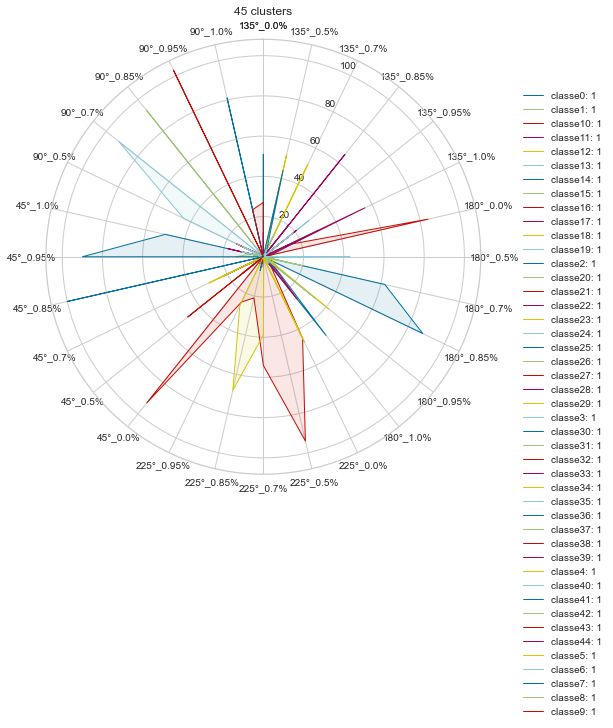

In [17]:
plot_cluster_radar(table, 'labels')

In [18]:
@interact
def plot_cluster_radar(cluster_label=list(table['labels'].unique())): 
    center=np.sum
    legend_loc=(1.3,0.9)
    """if dat.__class__.__name__ == 'DataFrame':
        hasClusterInDF = cluster_label.__class__.__name__ == 'str'
        noFeaturesGiven = features.__class__.__name__ == 'NoneType'"""
        
        #if noFeaturesGiven:
    features = table.columns.drop('labels').tolist()     
        #if hasClusterInDF:
    #cluster_labels = table['labels']
            
    data = table[features].values
    
    #if ax.__class__.__name__ == 'NoneType':
    fig, ax = plt.subplots(1, figsize=(15,15), subplot_kw={'projection': 'polar'})
        
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False) # Set the angle
    angles = np.concatenate((angles,[angles[0]]))
    features = np.concatenate((features,[features[0]]))
    ax.grid(True)
    ax.set_thetagrids(angles * 180/np.pi, features)
    #colorNames = list(matplotlib.colors.cnames.keys())
    #a=colorNames[0:135:3]
    #b=0
    #for i, group in enumerate(np.unique(cluster_labels)):
    indices = np.where(table['labels']==cluster_label)
        
        #if labels.__class__.__name__ != 'NoneType':
        #    group = labels[i]
        
    stats = center(data[indices], axis=0)
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, label=cluster_label)
    ax.fill(angles, stats, alpha=0.1)
    n_clusters = np.unique(cluster_label)
    ax.set_title("Carte radar des classes")
    ax.legend(loc='upper right', bbox_to_anchor=legend_loc)
    

interactive(children=(Dropdown(description='cluster_label', options=('classe0', 'classe1', 'classe10', 'classe…

In [19]:
@interact
def histo(cluster_label=list(table['labels'].unique())):
    fig, ax = plt.subplots(1,figsize=(10,5))
    dat[dat['labels']==cluster_label].groupby(['angle','obs']).count().unstack().plot(kind='bar',y='labels', stacked=True, ax=ax, title="classe"+str(k))


interactive(children=(Dropdown(description='cluster_label', options=('classe0', 'classe1', 'classe10', 'classe…

# Approche 2

In [20]:
data_final=[]
for i in set(data['angle']):
    v=0
    for j in set(data['obs']):
        if (i==90) & (j==0):
            print("")
        else:
            data1=data[(data['angle']==i) & (data['obs']==j)]
            data2i=extrac_features(data1[['rpm','temp', 'acc_x','acc_y','acc_z','gyr_x', 'gyr_y', 'gyr_z']])
            data2i["defaut"]=data1["defaut"].tolist()[0]
            data2i["angle"]=data1["angle"].tolist()[0]
            data2i["obs"]=data1["obs"].tolist()[0]
            data_final.append(data2i)
data22=pd.concat(data_final, ignore_index=True)

ValueError: No objects to concatenate

In [21]:
X= data22.drop(['defaut','obs', 'angle'], axis=1)
angle= data22['angle']
obs= data22['obs']

NameError: name 'data22' is not defined

ValueError: Found array with dim 3. Estimator expected <= 2.

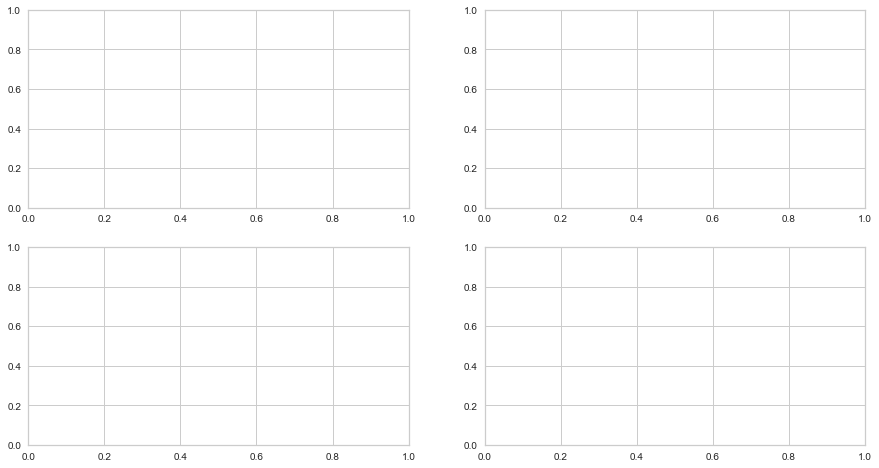

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
i=0
j=0
for k in [30, 35, 45,50]:
    
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[i,j])
    visualizer.fit(X)
    j=j+1
    if j==2:
        j=0
        i=i+1